In [1]:
"""
GAN Tutorial
References
http://intelligence.korea.ac.kr/members/wschoi/seminar/tutorial/mnist/pytorch/gan/GAN-%ED%8A%9C%ED%86%A0%EB%A6%AC%EC%96%BC/
https://github.com/yunjey/pytorch-tutorial/blob/master/tutorials/03-advanced/generative_adversarial_network/main.py#L41-L57
"""

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.utils as utils
import torchvision.datasets as dsets
import torchvision.transforms as transforms

cuda


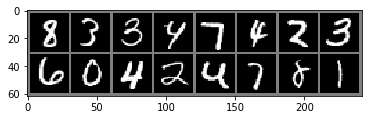

In [7]:
# device configuration
is_cuda = torch.cuda.is_available()
device = torch.device('cuda' if is_cuda else 'cpu')

# Transform for normalization
"""
# in the case of 3 RGB channel
transform = transforms.Compose([
                    transforms.ToTensor(),
                    transforms.Normalize(mean=(0.5, 0.5, 0.5),   
                                         std=(0.5, 0.5, 0.5))])
"""
transform = transforms.Compose([
                    transforms.ToTensor(),
                    transforms.Normalize(mean=[0.5],
                                         std=[0.5])])


# MNIST dataset
train_data = torchvision.datasets.MNIST(root='data/', train=True, transform=transform, download=True)
test_data  = torchvision.datasets.MNIST(root='data/', train=False, transform=transform, download=True)

batch_size = 200
train_data_loader = torch.utils.data.DataLoader(train_data, batch_size, shuffle=True)
test_data_loader  = torch.utils.data.DataLoader(test_data, batch_size, shuffle=True)

# To check MNIST image

import numpy as np
from matplotlib import pyplot as plt

def imshow(img):
    img = (img + 1) / 2
    img = img.squeeze()
    np_img = img.numpy()
    plt.imshow(np_img, cmap='gray')
    plt.show()


def imshow_grid(img):
    img = utils.make_grid(img.cpu().detach())
    img = (img + 1) / 2
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


example_mini_batch_img, example_mini_batch_label = next(iter(train_data_loader))
imshow_grid(example_mini_batch_img[0:16, :, :])

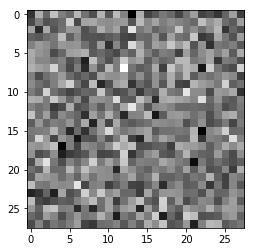

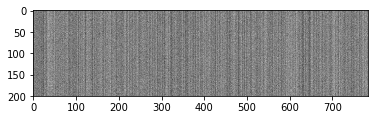

In [3]:
d_noise  = 100
d_hidden = 256

def sample_z(batch_size = 1, d_noise=100):
    return torch.randn(batch_size, d_noise, device=device)

G = nn.Sequential(
    nn.Linear(d_noise, d_hidden),
    nn.ReLU(),
    nn.Dropout(0.1),
    nn.Linear(d_hidden,d_hidden),
    nn.ReLU(),
    nn.Dropout(0.1),
    nn.Linear(d_hidden, 28*28),
    nn.Tanh()
).to(device)

# 노이즈 생성하기
z = sample_z()
# 가짜 이미지 생성하기
img_fake = G(z).view(-1,28,28)
# 이미지 출력하기
imshow(img_fake.squeeze().cpu().detach())

# Batch SIze만큼 노이즈 생성하여 그리드로 출력하기
z = sample_z(batch_size)
img_fake = G(z)
imshow_grid(img_fake)

In [4]:
D = nn.Sequential(
    nn.Linear(28*28, d_hidden),
    nn.LeakyReLU(),
    nn.Dropout(0.1),
    nn.Linear(d_hidden, d_hidden),
    nn.LeakyReLU(),
    nn.Dropout(0.1),
    nn.Linear(d_hidden, 1),
    nn.Sigmoid()
).to(device)

print(G(z).shape)
print(D(G(z)).shape)
print(D(G(z)[0:5]).transpose(0,1))

torch.Size([200, 784])
torch.Size([200, 1])
tensor([[0.5118, 0.5113, 0.5139, 0.5115, 0.5086]], device='cuda:0',
       grad_fn=<TransposeBackward0>)


In [5]:
criterion = nn.BCELoss()

def run_epoch(generator, discriminator, _optimizer_g, _optimizer_d):
    
    generator.train()
    discriminator.train()

    for img_batch, label_batch in train_data_loader:
        
        img_batch, label_batch = img_batch.to(device), label_batch.to(device) 

        # ================================================  #
        # maximize V(discriminator,generator) = optimize discriminator (setting k to be 1)  #
        # ================================================  #

        # init optimizer
        _optimizer_d.zero_grad()

        p_real = discriminator(img_batch.view(-1, 28*28))
        p_fake = discriminator(generator(sample_z(batch_size, d_noise)))

        # ================================================  #
        #    Loss computation (soley based on the paper)    #
        # ================================================  #
        loss_real = -1 * torch.log(p_real)   # -1 for gradient ascending
        loss_fake = -1 * torch.log(1.-p_fake) # -1 for gradient ascending
        loss_d    = (loss_real + loss_fake).mean()
        
        # ================================================  #
        #     Loss computation (based on Cross Entropy)     #
        # ================================================  #
        # loss_d = criterion(p_real, torch.ones_like(p_real).to(device)) + \    #
        #          criterion(p_fake, torch.zeros_like(p_real).to(device))       #
        
        # Update parameters
        loss_d.backward()
        _optimizer_d.step()

        # ================================================  #
        #        minimize V(discriminator,generator)        #
        # ================================================  #

        # init optimizer
        _optimizer_g.zero_grad()

        p_fake = discriminator(generator(sample_z(batch_size, d_noise)))
                
        # ================================================  #
        #    Loss computation (soley based on the paper)    #
        # ================================================  #
        
        # instead of: torch.log(1.-p_fake).mean() <- explained in Section 3
        loss_g = -1 * torch.log(p_fake).mean() 

        # ================================================  #
        #     Loss computation (based on Cross Entropy)     #
        # ================================================  #
        # loss_g = criterion(p_fake, torch.ones_like(p_fake).to(device)) #

        loss_g.backward()
   
        # Update parameters
        _optimizer_g.step()

def evaluate_model(generator, discriminator):
    
    p_real, p_fake = 0.,0.
    
    generator.eval()
    discriminator.eval()
        
    for img_batch, label_batch in test_data_loader:
        
        img_batch, label_batch = img_batch.to(device), label_batch.to(device) 
        
        with torch.autograd.no_grad():
            p_real += (torch.sum(discriminator(img_batch.view(-1, 28*28))).item())/10000.
            p_fake += (torch.sum(discriminator(generator(sample_z(batch_size, d_noise)))).item())/10000.
            
            
    return p_real, p_fake

(epoch 5/200) p_real: 0.990377, p_g: 0.011688


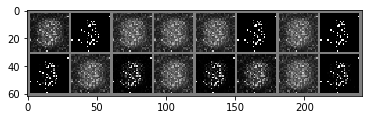

(epoch 10/200) p_real: 0.997834, p_g: 0.004834


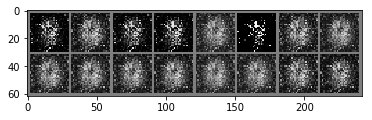

(epoch 15/200) p_real: 0.982530, p_g: 0.022954


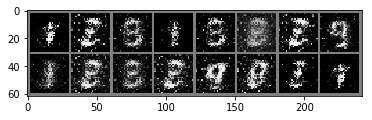

(epoch 20/200) p_real: 0.958099, p_g: 0.057923


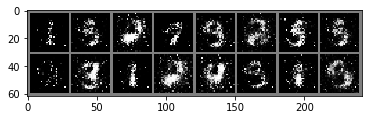

(epoch 25/200) p_real: 0.939345, p_g: 0.053620


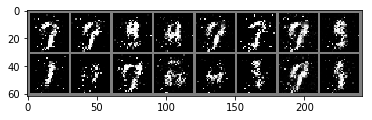

(epoch 30/200) p_real: 0.890233, p_g: 0.150697


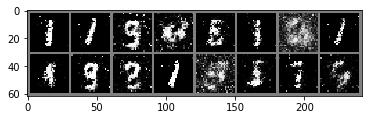

(epoch 35/200) p_real: 0.868796, p_g: 0.151646


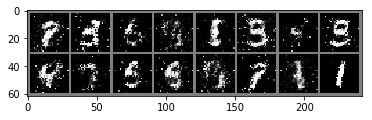

(epoch 40/200) p_real: 0.804774, p_g: 0.167258


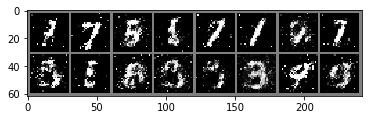

(epoch 45/200) p_real: 0.760741, p_g: 0.237690


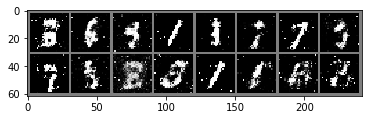

(epoch 50/200) p_real: 0.746748, p_g: 0.190348


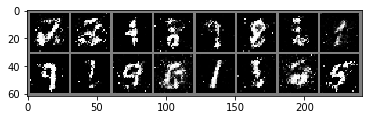

(epoch 55/200) p_real: 0.695765, p_g: 0.206263


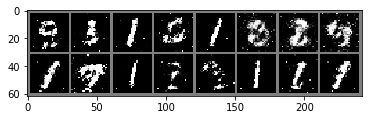

(epoch 60/200) p_real: 0.728155, p_g: 0.217669


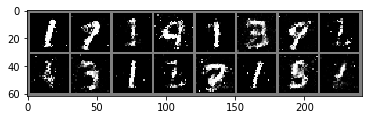

(epoch 65/200) p_real: 0.696408, p_g: 0.251930


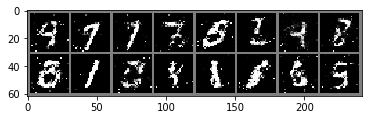

(epoch 70/200) p_real: 0.715843, p_g: 0.280139


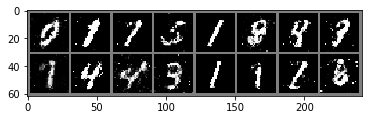

(epoch 75/200) p_real: 0.686380, p_g: 0.261631


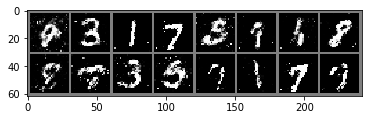

(epoch 80/200) p_real: 0.709255, p_g: 0.296763


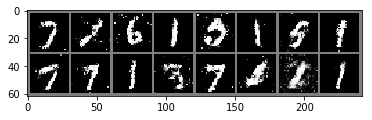

(epoch 85/200) p_real: 0.676677, p_g: 0.286581


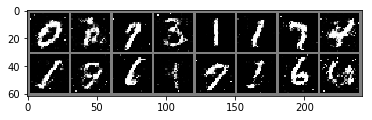

(epoch 90/200) p_real: 0.651269, p_g: 0.276429


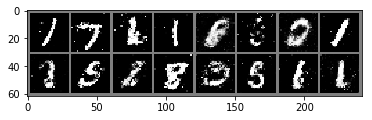

(epoch 95/200) p_real: 0.647240, p_g: 0.294845


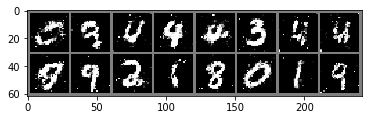

(epoch 100/200) p_real: 0.600475, p_g: 0.203235


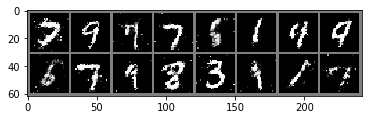

(epoch 105/200) p_real: 0.631653, p_g: 0.269389


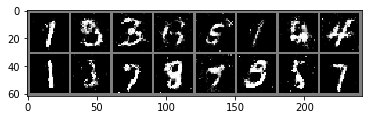

(epoch 110/200) p_real: 0.604967, p_g: 0.206152


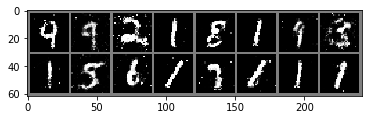

(epoch 115/200) p_real: 0.662968, p_g: 0.298044


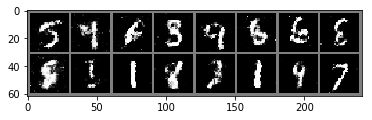

(epoch 120/200) p_real: 0.647414, p_g: 0.336939


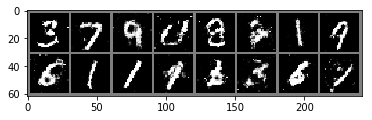

(epoch 125/200) p_real: 0.600231, p_g: 0.254174


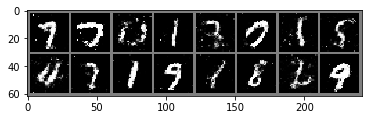

(epoch 130/200) p_real: 0.677149, p_g: 0.286351


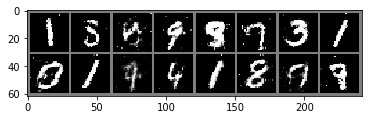

(epoch 135/200) p_real: 0.658646, p_g: 0.363468


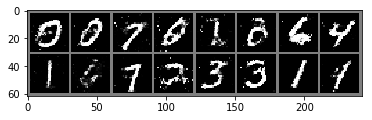

(epoch 140/200) p_real: 0.667346, p_g: 0.363159


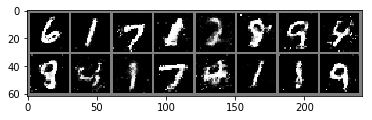

(epoch 145/200) p_real: 0.590447, p_g: 0.279937


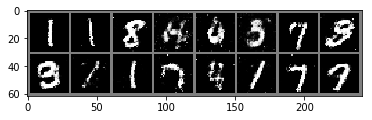

In [ ]:
def init_params(model):
    for p in model.parameters():
        if(p.dim() > 1):
            nn.init.xavier_normal_(p)
        else:
            nn.init.uniform_(p, 0.1, 0.2)

init_params(G)
init_params(D)

optimizer_g = optim.Adam(G.parameters(), lr = 0.0002)
optimizer_d = optim.Adam(D.parameters(), lr = 0.0002)

p_real_trace = []
p_fake_trace = []

for epoch in range(200):
    run_epoch(G, D, optimizer_g, optimizer_d)
    p_real, p_fake = evaluate_model(G,D)
    
    p_real_trace.append(p_real)
    p_fake_trace.append(p_fake) 
    
    if((epoch+1)% 50 == 0):
        print('(epoch %i/200) p_real: %f, p_g: %f' % (epoch+1, p_real, p_fake))
        imshow_grid(G(sample_z(16)).view(-1, 1, 28, 28))

In [ ]:
plt.plot(p_fake_trace, label='D(x_generated)')
plt.plot(p_real_trace, label='D(x_real)')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.show()

In [ ]:
vis_loader = torch.utils.data.DataLoader(test_data, 16, True)
img_vis, label_vis   = next(iter(vis_loader))
imshow_grid(img_vis)

imshow_grid(G(sample_z(16,100)).view(-1, 1, 28, 28))